In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 9, 6
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from keras import backend as K
K.set_learning_phase(1)
%run survey_lcs.py 64 2 0.25 --no_train --model_type gru --lr 5e-4 --sim_type survey_lcs/n200 --nb_epoch 1 --n_min 200 --n_max 200 --m_max 32 --embedding 64

Using TensorFlow backend.
/Users/brettnaul/Dropbox/Documents/timeflow/survey_lcs.py:44: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  X_list = [pd.read_csv(f, header=None).sort(columns=0).values for f in filenames]


[]
/Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/survey_lcs/n200/gru_064_x2_5m04_drop25_emb64
Loading /Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/survey_lcs/n200/gru_064_x2_5m04_drop25_emb64/weights.h5...


# Visualizing predictions

In [3]:
%%time
pred = model.predict({'main_input': X, 'aux_input': X[:, :, [0, 2]]}, batch_size=500)

CPU times: user 18min 17s, sys: 5min 38s, total: 23min 55s
Wall time: 5min 12s


In [4]:
i = -1

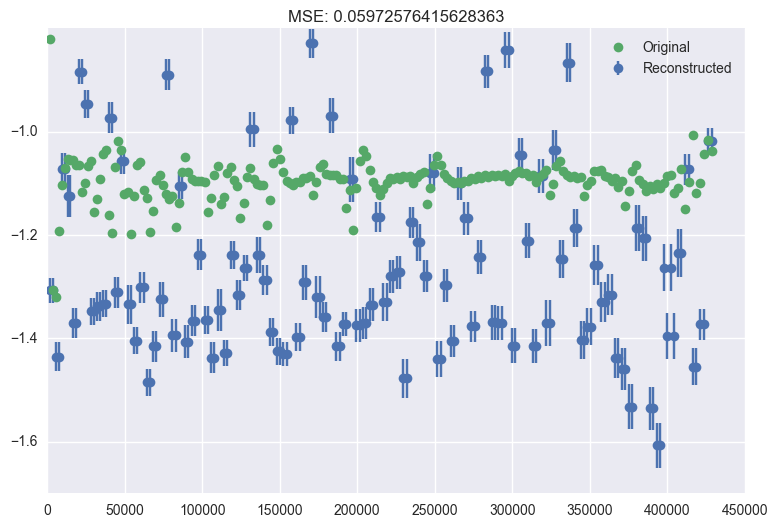

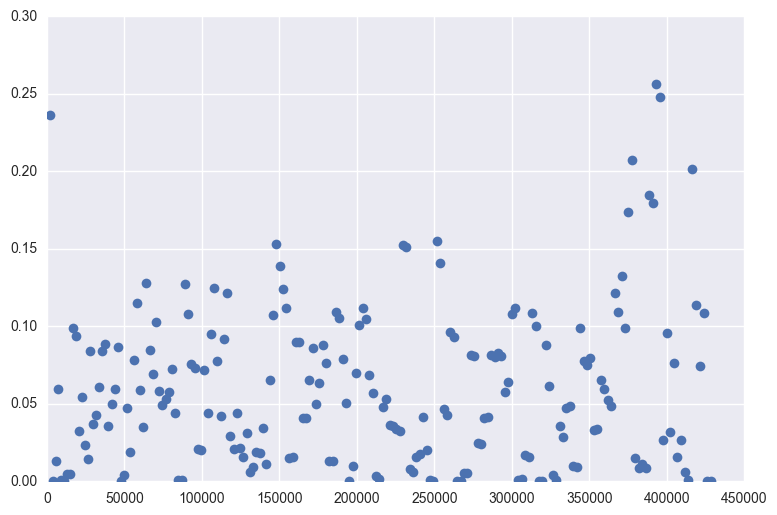

In [18]:
i += 1
#inds = ~np.isnan(X_raw[i, :, 0])
inds = np.arange(args.n_min)
t = np.cumsum(X_raw[i, inds, 0])
m = X[i, inds, 1]
e = X[i, inds, 2]
pred_i = model.predict({'main_input': X[i:i+1], 'aux_input': X[i:i+1, :, [0, 2]]})[0, inds, 0]

plt.errorbar(t, m, e, None, 'o');
plt.plot(t, pred[i], 'o');

#w_r, A_r, phi_r, b_r = pred_gru[i]
#x_r = A_r * np.sin(2 * np.pi * w_r * t + phi_r) + b_r
#plt.plot(t, x_r, '--')

plt.legend(['Original', 'Reconstructed'])
plt.title("MSE: {}".format(np.mean((m - np.squeeze(pred[i])) ** 2)));

plt.figure()
plt.plot(t, (m - np.squeeze(pred[i])) ** 2, 'o');

/Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:343: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


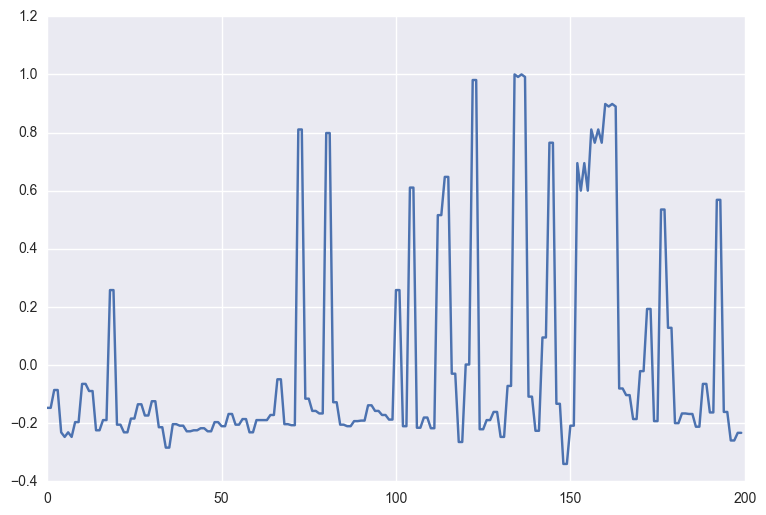

In [44]:
X[:, :, 1] /= np.atleast_2d(np.nanmax(np.abs(X[:, :, 1]), axis=1)).T
plt.plot(X[1, :, 1])

# Visualizing training progress

In [ ]:
import glob
import os

log_files = glob.glob(os.path.join('keras_logs', 'autoencoder/uneven/noise0') + '/*.csv')
logs = [pd.read_csv(f, usecols=['Wall time', 'Step', 'Value']) for f in log_files]
for log, f in zip(logs, log_files):
    label = f[(f.rfind('run_') + 4):f.rfind(',')] + ' ' + ('Validation' if 'val' in f else 'Training')
    log.columns = [label if c == 'Value' else c for c in log.columns]
    log['Wall time'] -= log['Wall time'].min()
time_logs = pd.concat([l.set_index('Wall time').drop('Step', axis=1) for l in logs], axis=1)
step_logs = pd.concat([l.set_index('Step').drop('Wall time', axis=1) for l in logs], axis=1)
step_logs.head(10)

In [ ]:
step_logs.plot?

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

colors = sns.color_palette(n_colors=int(len(step_logs.columns) / 2))
for i, c in enumerate(step_logs.columns):
    step_logs[c].dropna().plot(ax=ax[0], color=colors[int(i / 2)], legend=True, linestyle='-' if 'Training' in c else '--')
    time_logs[c].dropna().plot(ax=ax[1], color=colors[int(i / 2)], legend=True, linestyle='-' if 'Training' in c else '--')
ax[0].set_ylabel('Loss');
ax[1].set_ylabel('Loss');
ax[1].set_xlabel('Wall time (s)');

# Visualizing embeddings

In [ ]:
%%time
inds = np.arange(args.N_train, args.N_train + args.N_test)
encode_layer = [l for l in model.layers if l.name == 'encoding'][0]
if args.even:
    encode = K.function([model.layers[0].input], [encode_layer.output])
    encoding, = encode([X[inds]])
else:
    inputs = [l for l in model.layers if 'Input' in str(l)]
    encode = K.function([inputs[0].input, inputs[1].input], [encode_layer.output])
    encoding, = encode([X[inds], X[inds, :, 0:1]])

In [ ]:
np.mean((m - pred_i) ** 2)

In [ ]:
S = np.corrcoef(encoding, Y[:encoding.shape[0]], rowvar=0)[:8, 8:]
print(pd.DataFrame(S))
plt.imshow(S, cmap='viridis', interpolation='none')
plt.colorbar()

In [ ]:
sns.jointplot(encoding[:, 5], Y[:encoding.shape[0], 0], kind='hex')

In [ ]:
sns.jointplot(encoding[:, 1], Y[:encoding.shape[0], 1], kind='hex')

In [ ]:
sns.jointplot(encoding[:, 5], Y[:encoding.shape[0], 2], kind='hex')

In [ ]:
sns.jointplot(encoding[:, 3], Y[:encoding.shape[0], 3], kind='hex')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

model = RandomForestRegressor(n_estimators=128)
#model = ElasticNet()
#model = SVR(kernel='rbf')

model.fit(encoding, Y[:encoding.shape[0], 0])

In [ ]:
encoding_test = encode([X[test]])[0]
Y_pred = model.predict(encoding_test)

In [ ]:
#sns.jointplot(Y[test, 0], Y_pred[:, 0])
sns.jointplot(Y[test, 0], Y_pred)